# MIMIC-III and Support2Cls Data

## MIMIC-III

In [2]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from utils import eval_model, perturb_labels_fp, update_model_online_feedback, make_gaussian_data

%matplotlib inline

In [3]:
def load_mimiciii_data():
    df_adult = pd.read_csv('adult_icu.gz', compression='gzip')
    
    train_cols = [
    'age', 'first_hosp_stay', 'first_icu_stay', 'eth_asian',
    'eth_black', 'eth_hispanic', 'eth_other', 'eth_white',
    'admType_ELECTIVE', 'admType_EMERGENCY', 'admType_NEWBORN',
    'admType_URGENT', 'heartrate_min', 'heartrate_max', 'heartrate_mean',
    'sysbp_min', 'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max',
    'diasbp_mean', 'meanbp_min', 'meanbp_max', 'meanbp_mean',
    'resprate_min', 'resprate_max', 'resprate_mean', 'tempc_min',
    'tempc_max', 'tempc_mean', 'spo2_min', 'spo2_max', 'spo2_mean',
    'glucose_min', 'glucose_max', 'glucose_mean', 'aniongap', 'albumin',
    'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose',
    'hematocrit', 'hemoglobin', 'lactate', 'magnesium', 'phosphate',
    'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc']
    
    label = 'mort_icu'
    X_df = df_adult[train_cols]
    y_df = df_adult[label]
    
    dataset = {
    'problem': 'classification',
    'X': X_df,
    'y': y_df,
    'd_name': 'mimiciii',
    }
    
    return dataset

In [7]:
data = load_mimiciii_data()
x = data["X"].to_numpy()
y = data["y"].to_numpy()


In [27]:
print("Positive Samples: {}".format(np.sum(y == 1) / float(len(y))))
print("Negative Samples: {}".format(np.sum(y == 0) / float(len(y))))

Positive Samples: 0.09839842035980693
Negative Samples: 0.901601579640193


In [19]:
seeds = np.arange(10)

num_updates = [1, 10, 25, 50, 75, 100]
names = ["fpr", "tpr", "fnr", "tnr"]
rates = {name: {update: {"initial": [], "updated": []} for update in num_updates} for name in names}

for seed in seeds:
    print(seed)
    for update in num_updates:
        np.random.seed(seed)

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6)
        x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=0.5)

        model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

        new_model = update_model_online_feedback(model, x_update, y_update, update)

        y_pred = new_model.predict(x_test)
        updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

        rates["fpr"][update]["initial"].append(initial_fpr)
        rates["tpr"][update]["initial"].append(initial_tpr)
        rates["fnr"][update]["initial"].append(initial_fnr)
        rates["tnr"][update]["initial"].append(initial_tnr)
        
        rates["fpr"][update]["updated"].append(updated_fpr)
        rates["tpr"][update]["updated"].append(updated_tpr)
        rates["fnr"][update]["updated"].append(updated_fnr)
        rates["tnr"][update]["updated"].append(updated_tnr)

0
1
2
3
4
5
6
7
8
9


In [23]:
data = {"rate": [], "type": [], "num_updates": [], "time": []}

for name in names:
    for update in num_updates:
        data["rate"] += rates[name][update]["initial"]
        data["type"] += [name] * len(rates[name][update]["initial"])
        data["num_updates"] += [update] * len(rates[name][update]["initial"])
        data["time"] += ["initial"] * len(rates[name][update]["initial"])

        data["rate"] += rates[name][update]["updated"]
        data["type"] += [name] * len(rates[name][update]["updated"])
        data["num_updates"] += [update] * len(rates[name][update]["updated"])
        data["time"] += ["updated"] * len(rates[name][update]["updated"])

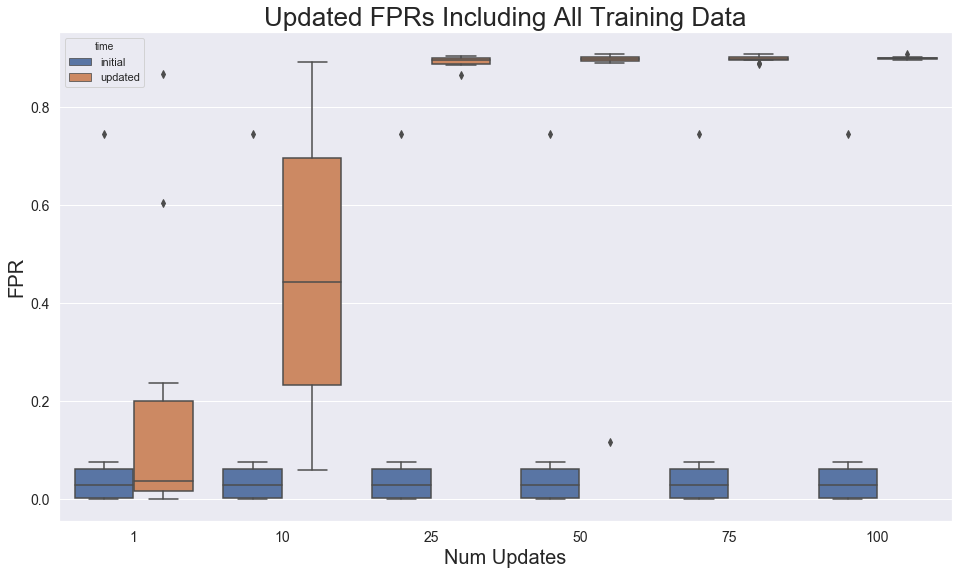

In [25]:
data = pd.DataFrame(data)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="num_updates", y="rate", hue="time", data=data.loc[data["type"] == "fpr"], ax=ax)
# sns.swarmplot(x="type", y="rate", hue="time", data=data, color=".25", ax=ax)
ax.set_xlabel("Num Updates", size=20)
ax.set_ylabel("FPR", size=20)
ax.set_title("Updated FPRs Including All Training Data", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

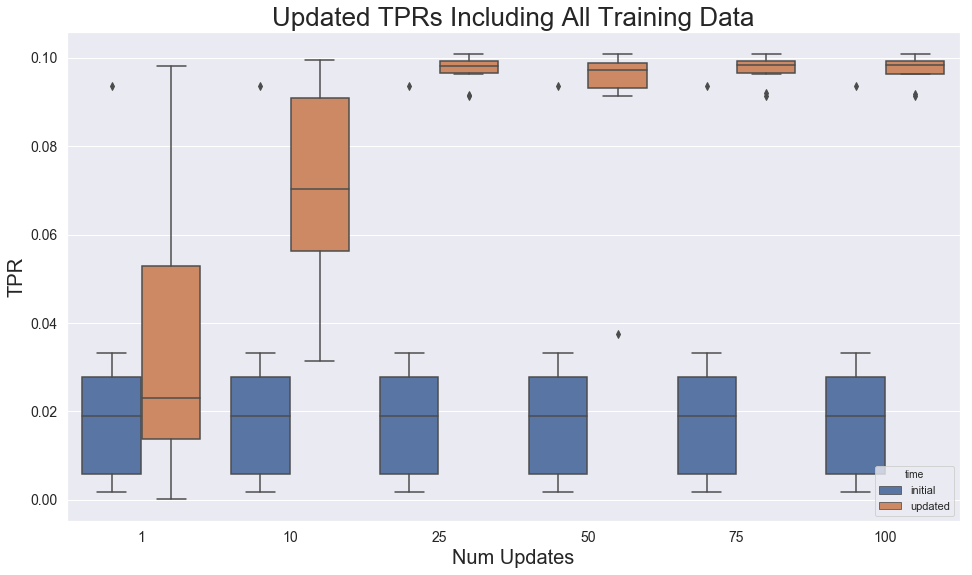

In [26]:
data = pd.DataFrame(data)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="num_updates", y="rate", hue="time", data=data.loc[data["type"] == "tpr"], ax=ax)
# sns.swarmplot(x="type", y="rate", hue="time", data=data, color=".25", ax=ax)
ax.set_xlabel("Num Updates", size=20)
ax.set_ylabel("TPR", size=20)
ax.set_title("Updated TPRs Including All Training Data", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

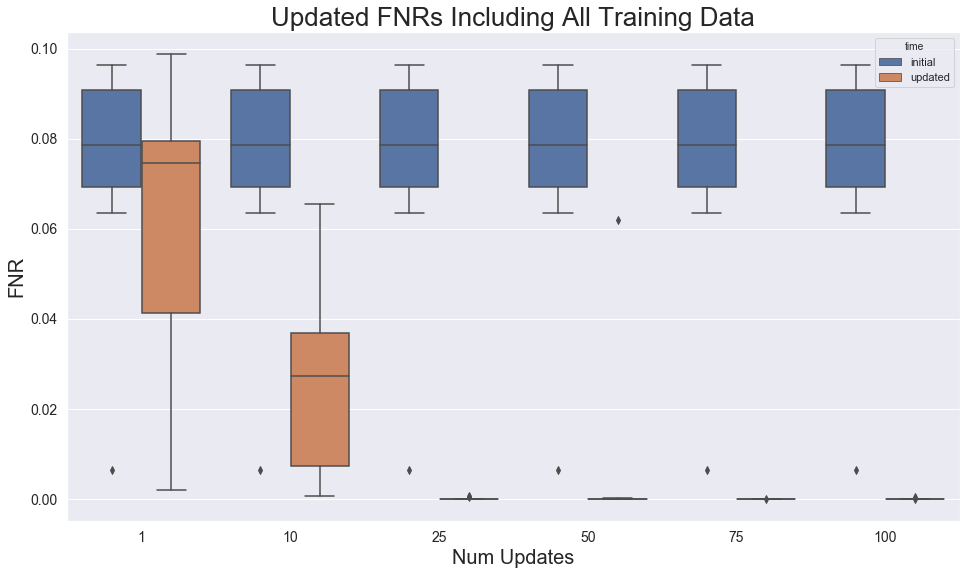

In [28]:
data = pd.DataFrame(data)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="num_updates", y="rate", hue="time", data=data.loc[data["type"] == "fnr"], ax=ax)
# sns.swarmplot(x="type", y="rate", hue="time", data=data, color=".25", ax=ax)
ax.set_xlabel("Num Updates", size=20)
ax.set_ylabel("FNR", size=20)
ax.set_title("Updated FNRs Including All Training Data", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)